<a href="https://colab.research.google.com/github/yudhapatria96/Analyzing-Indonesia-s-Income-Inequality/blob/main/Analyzing_Indonesia%E2%80%99s_Income_Inequality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
!pip install geopandas

In [45]:
!pip install seaborn
!pip install descartes
!pip install pysal
!pip install mapclassify

In [46]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import descartes
from sklearn import cluster
import pysal as ps
import mapclassify
%matplotlib inline

In [47]:
#@title Default title text
# Load the Shapefile
gdf = gpd.read_file('./drive/MyDrive/Semua Tentang Data/data_income/idn_admbnda_adm2_bps_20200401.shp')
## Removing the prefix 'Kota' ('City' in English)
gdf['ADM2_EN'] = gdf['ADM2_EN'].str.replace('Kota ', '')

# Load the GDP_per_capita CSV and fill the NA value with 0
city_df = pd.read_csv('./drive/MyDrive/Semua Tentang Data/data_income/city_gdp.csv', index_col=0)
city_df = city_df.fillna(0)
city_df = city_df.drop(['ADM1_EN'], axis=1)
city_df

,ADM2_EN,gdp_capita
0,Aceh Barat,34426.0
2,Aceh Besar,28436.0
3,Aceh Jaya,0.0
4,Aceh Selatan,20939.0
5,Aceh Singkil,17986.0
...,...,...
517,Way Kanan,27518.0
518,Wonogiri,26292.0
519,Wonosobo,20767.0
520,Yahukimo,11214.0


In [48]:
# Table join using ADM2_EN as key
joined_df = gdf.join(city_df.set_index('ADM2_EN'), on='ADM2_EN')
joined_df['gdp_capita'] = joined_df['gdp_capita'].fillna(0)

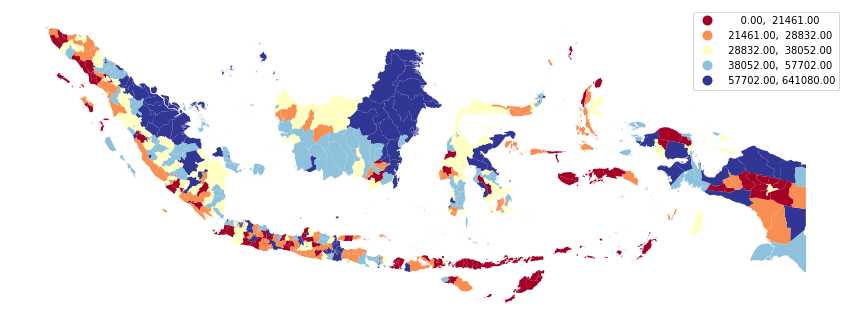

In [49]:
# Plot based on quantiles
fig = joined_df.plot(column='gdp_capita',
               cmap='RdYlBu',
               legend=True,
               scheme='quantiles',
               figsize=(15, 10)
)
ax = fig
ax.set_axis_off()

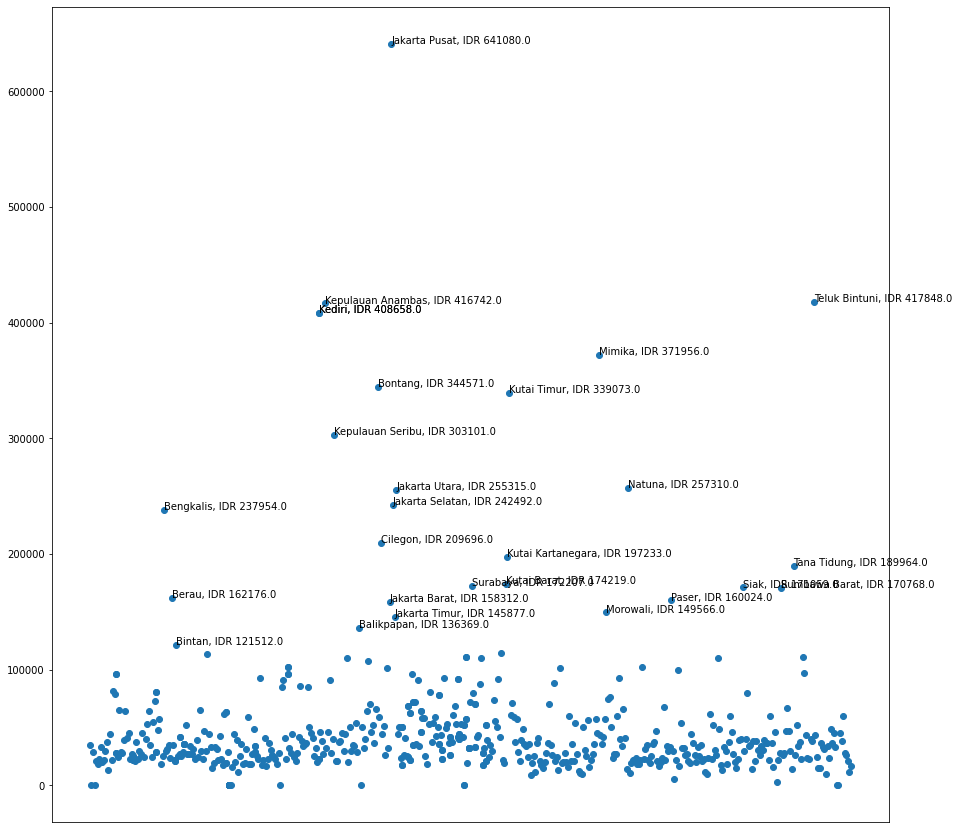

In [50]:
fig, ax = plt.subplots(figsize=(15,15))
x = joined_df['ADM2_EN'].array
y = joined_df['gdp_capita'].array
ax.scatter(x, y)
ax.axes.get_xaxis().set_ticks([])
for i, city in enumerate(x):
    if y[i] > 120000:
        label = city + ", IDR " + str(y[i])
    else:
        label = ''
    ax.annotate(label, (x[i], y[i]))

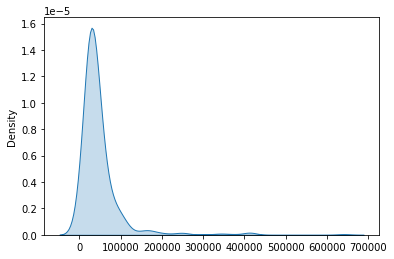

In [51]:
sns.kdeplot(y, shade=True)

In [52]:
km4 = cluster.KMeans(n_clusters=4)
km4cls = km4.fit(joined_df[['gdp_capita']].values)

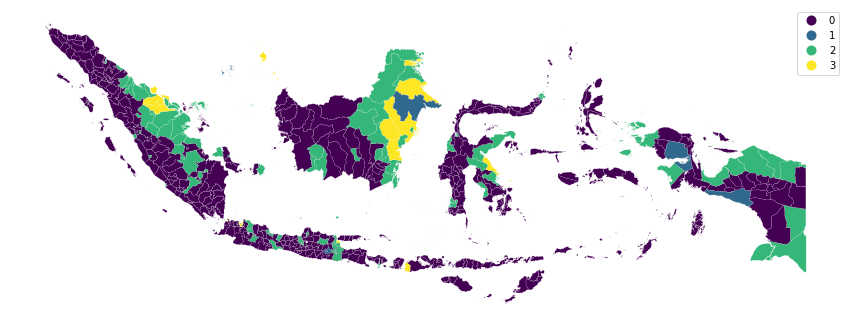

In [53]:
f, ax = plt.subplots(1, figsize=(15, 15))
joined_df.assign(cl=km4cls.labels_).plot(column='cl', 
                                         categorical=True, 
                                         legend=True, 
                                         linewidth=0.1, 
                                         edgecolor='white', 
                                         cmap='viridis', 
                                         ax=ax)
ax.set_axis_off()
plt.show()

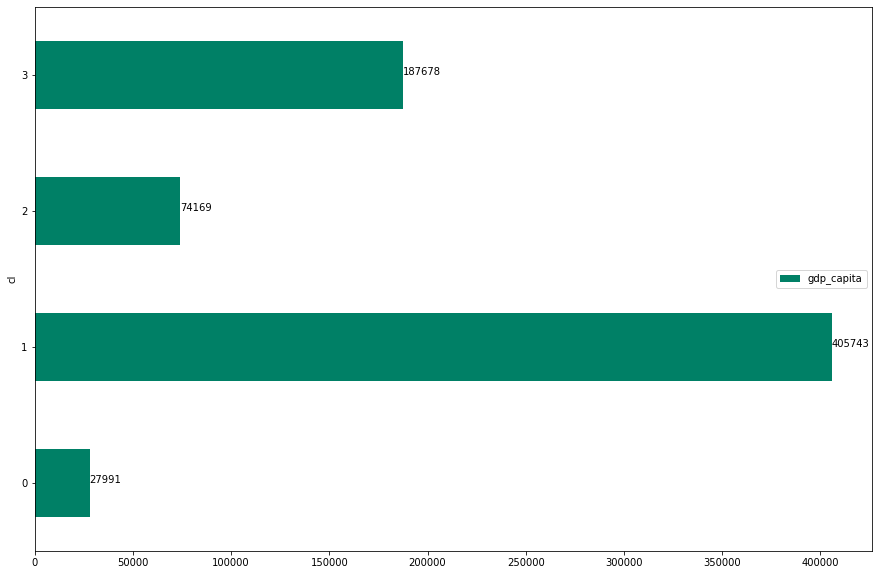

In [54]:
# Getting the underlying statistics (average GDP per capita)
cl_pcts = joined_df.drop(['Shape_Leng', 'Shape_Area'], axis=1).assign(cl=km4cls.labels_).groupby('cl').mean()
f, ax = plt.subplots(1, figsize=(15, 10))
cl_pcts.plot(kind='barh', 
             stacked=True, 
             ax=ax, 
             cmap='summer', 
             linewidth=0)
ax.legend(ncol=1, loc='right')
for index, value in enumerate(cl_pcts['gdp_capita']):
    value = int(value)
    ax.text(value, index, str(value))